In [ ]:
#version for used unpickling model on server -> scikit-learn 1.3.2 (latest version as of 09-01-2024)
#!pip install scikit-learn == 1.3.2
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3
import joblib
import ast
import re

# Data Cleaning and Preprocessing

In [ ]:
db_path = "devdb.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM `fingerprints`", conn)

In [ ]:
df.head()

,id,location_tag,fingerprint
0,1,SB 305,"(-64, 1) (-64, 1) (-67, 1) (-67, 1) (-68, 1) (..."
1,2,SB 305,"(-64, 1) (-64, 1) (-67, 1) (-67, 1) (-67, 1) (..."
2,3,SB 305,"(-68, 1) (-68, 1) (-66, 1) (-65, 1) (-66, 1) (..."
3,4,SB 305,"(-63, 1) (-63, 1) (-67, 1) (-67, 1) (-67, 1) (..."
4,5,SB 305,"(-60, 1) (-60, 1) (-67, 1) (-67, 1) (-67, 1) (..."


In [ ]:
df.tail()

,id,location_tag,fingerprint
1682,1683,SB 304,"(-92, 1) (-89, 1) (-88, 1) (-86, 1) (-87, 1) (..."
1683,1684,SB 304,"(-89, 1) (-90, 1) (-86, 1) (-86, 1) (-86, 1) (..."
1684,1685,SB 304,"(-84, 1) (-84, 1) (-86, 1) (-86, 1) (-85, 1) (..."
1685,1686,SB 304,"(-84, 1) (-84, 1) (-87, 1) (-86, 1) (-85, 1) (..."
1686,1687,SB 304,"(-84, 1) (-84, 1) (-87, 1) (-88, 1) (-85, 1) (..."


In [ ]:
df['location_tag'].value_counts()

SB 305    505
SB 313    502
SB 304    416
SB 302    264
Name: location_tag, dtype: int64

In [ ]:
# n    -> first n samples
# m    -> number of bins
# k    -> number of samples to randomly sel from bins
# room -> location tag

#SB 305: 28 * 18 = 504
#SB 313: 27 * 18 = 486
#SB 304: 23 * 18 = 414
#SB 302: 15 * 18 = 264

def stratify_nd_sample(df, n, m, k, room):
    result = pd.DataFrame()

    room_data = df[df['location_tag'] == room].sort_values('id').head(n)
    bins = pd.cut(np.arange(len(room_data)), bins=m)
    grouped = room_data.groupby(bins)

    for _, group in grouped:
      selected_samples = group.sample(k)
      result = pd.concat([result, selected_samples])

    return result.sort_values('id')


df_filtr = pd.DataFrame(columns=df.columns)
df_filtr = pd.concat([df_filtr,
                      stratify_nd_sample(df, 504, 18, 14, 'SB 305'),
                      stratify_nd_sample(df, 486, 18, 14, 'SB 313'),
                      stratify_nd_sample(df, 414, 18, 14, 'SB 304'),
                      stratify_nd_sample(df, 264, 18, 14, 'SB 302')])


In [ ]:
df_filtr['location_tag'].value_counts()

SB 305    252
SB 313    252
SB 304    252
SB 302    252
Name: location_tag, dtype: int64

In [ ]:
df_copy = df_filtr.copy(deep = True)

In [ ]:
df_copy['fingerprint'] = df['fingerprint'].str.replace("?", "(0,0)")

<ipython-input-8-e7e2754dbbc3>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_copy['fingerprint'] = df['fingerprint'].str.replace("?", "(0,0)")


In [ ]:
df_copy.tail()

,id,location_tag,fingerprint
764,765,SB 302,"(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0..."
765,766,SB 302,"(0,0) (0,0) (0,0) (0,0) (0,0) (-87, 1) (-91, 1..."
766,767,SB 302,"(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0..."
767,768,SB 302,"(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0..."
768,769,SB 302,"(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0..."


In [ ]:
df_copy['fingerprint'] = df_copy['fingerprint'].apply(lambda x: re.findall(r'\([^)]*\)', x))

df_copy['fingerprint'] = df_copy['fingerprint'].apply(lambda x: [ast.literal_eval(item)[0] for item in x])


In [ ]:
df_copy.tail()

,id,location_tag,fingerprint
764,765,SB 302,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -90, -90,..."
765,766,SB 302,"[0, 0, 0, 0, 0, -87, -91, -89, 0, 0, 0, 0, 0, ..."
766,767,SB 302,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
767,768,SB 302,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -93, 0, 0..."
768,769,SB 302,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#sometimes, a BSSID = 0 is returned alongside the scan results
#Quick fix:
  #find the index where BSSID = 0 in fv_ordering table (say k)
  #where len(feature vector) > k, remove all (k - 1)th feature in the feature vectors in df

conn = sqlite3.connect(db_path)
query = "SELECT rowid FROM fv_ordering WHERE BSSID = 0;"
cursor = conn.cursor()
cursor.execute(query)
result = cursor.fetchall()

conn.close()
if len(result) > 0:
  k = [row[0] for row in result][0]
else:
  k = None

print("Index where BSSID is equal to 0:", k)

Index where BSSID is equal to 0: None


In [ ]:
#recall sqlite indexing starts 1
#observe the 16th index for a few rows
for i in range(1,50):
  if k is None: break
  print(df_copy['fingerprint'][i][16], end = " ")

In [ ]:
#Drop all elements at index 16
def drop_16th(arr):
    if len(arr) >= 17:
        arr.pop(16)
    return arr

df_copy['fingerprint'] = df_copy['fingerprint'].apply(drop_16th)

In [ ]:
#observe the 16th index for a few rows
for i in range(1,20):
  print(df_copy['fingerprint'][i][16], end = " ")

-88 -88 -88 -88 -86 -85 -88 -89 -91 -89 -83 -86 -89 0 -88 -89 -89 0 -88 

# Exploratory Data Analysis

In [ ]:
#Calculate the total number of wireless access points(WAPs) caputured during the scan

conn = sqlite3.connect(db_path)
table_name = "fv_ordering"
query = f"SELECT COUNT(*) FROM {table_name}"
cursor = conn.cursor()
cursor.execute(query)
number_of_entries = cursor.fetchone()[0]

conn.close()

print(f"Total No of WAPs '{table_name}': {number_of_entries}")


Total No of WAPs 'fv_ordering': 94


In [ ]:
#Calculate average number of WAPs sensed in each scan

def count_nonzero(arr):
    return sum(1 for elem in arr if elem != 0)


non_zero = df_copy['fingerprint'].apply(count_nonzero).mean()

non_zero

13.288690476190476

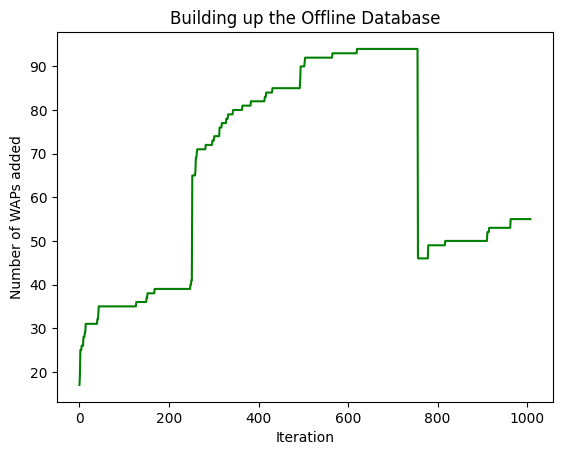

In [ ]:
#length of the feature vectors (how the offline db was built up)

arr_lens = df_copy['fingerprint'].apply(len)
positions = range(len(arr_lens))

#create a bar plot
plt.plot(positions, arr_lens, linestyle='-', color='green')
plt.title('Building up the Offline Database')
plt.xlabel('Iteration')
plt.ylabel('Number of WAPs added')
plt.show()


In [ ]:
#make all feature vector equals
max_len = df_copy['fingerprint'].apply(len).max()

def pad_zeros(arr):
    return arr + [0] * (max_len - len(arr))

df_copy['fingerprint'] = df_copy['fingerprint'].apply(pad_zeros)

# Fingerprints Clustering using KNN

In [ ]:
X = df_copy['fingerprint'].tolist()
y = df_copy['location_tag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=10))
knn_model.fit(X_train, y_train)

accuracy = knn_model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.9900990099009901


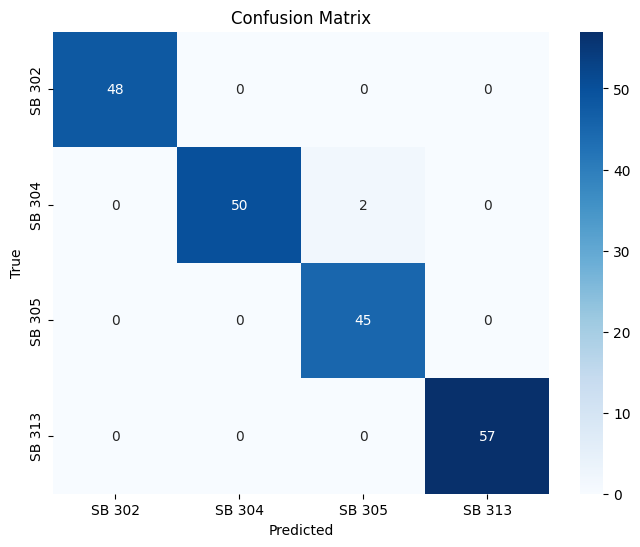

In [ ]:
# Create the confusion confusion matrix

y_pred = knn_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have obtained the confusion matrix 'cm'
y_pred = knn_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.9905
Recall: 0.9901
F1 Score: 0.9901


In [ ]:
#export model
filename = 'knn_loc_algorithm.sav'
joblib.dump(knn_model, filename)

['knn_loc_algorithm.sav']